| 주차 | 일정                               | 페이지                                  |
|-----:|-----------------------------------|----------------------------------------|
|    1 | 1장-헬로 파이썬                     | 0p ~ 45p                               |
|    2 | 2장-퍼셉트론                        | 46p ~ 62p                              |
|    3 | 3장-신경망                          | 63p ~ 105p                             |
|    4 | 4장-신경망 학습                     | 106p ~ 146p                            |
|    5 | 5장-오차역전파법                    | 147p ~ 187p (+ Appendix A, 292p ~ 299p) |
|    6 | 중간고사(전)                        |                                        |
|    7 | 중간고사                           |                                        |
|    8 | 6장-학습 관련 기술들               | 188p ~ 226p                            |
|    9 | 7장-합성곱 신경망(CNN)             | 227p ~ 259p                            |
|   10 | 딥러닝                             | 261p ~ 308p                            |
|   11 | 1장-신경망 복습                    | 0p ~ 74p (+ Appendix A, 389p ~ 394p)  |
|   12 | 2장-자연어와 단어의 분산 표현      | 78p ~ 113p (+ Appendix B, 395p ~ 399p) |
|   13 | 기말고사(전)                       |                                        |
|   14 | 기말고사                          |                                        |
|   15 | 3장-word2vec                       | 114p ~ 147p                            |
|   16 | 4장-word2vec 속도 개선             | 148p ~ 189p                            |
|   17 | 5장-순환신경망(RNN)                | 190p ~ 235p                            |
|   18 | 6장-게이트가 추가된 RNN            | 263p ~ 286p (+ Appendix C, 401p ~ 402p)|
|   19 | 7장-RNN을 사용한 문장 생성         | 287p ~ 333p                            |
|   20 | 8장-어텐션                         | 334p ~ 387p                            |

# 19주차

게이트가 추가된 RNN

_290p ~ 317p_ (쪼갬)

---

### 7.1 언어모델을 사용한 문장 생성

새로운 문장생성 모델인 seq2seq가 있는데 이는 한 시계열 데이터를 다른 시계열 데이터로 바꾸는 모델로서 기계번역, 챗봇, 메일답장 등에 사용할 수 있다.

전에 RNN을 쓴 모델의 경우에는 token하나를 주면 그 다음에 나올 token를 예측하는 방식으로 다음과같이 동작을 했었다.

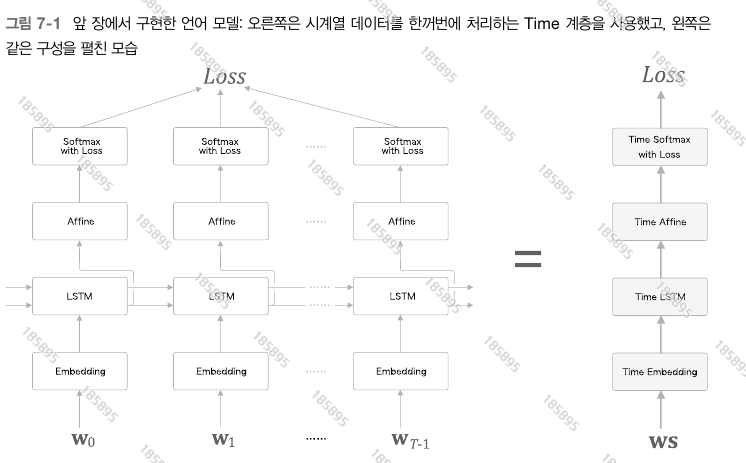

이 모델이 생성하는 문장을 '결정적' 또는 '확률적'인 방식으로 분류할 수 있다. 결정적인 방식은 다음 token후보들 중 가장 높은확률을 그냥 고르는거고 확률적인 방식은 다음 나올 token의 확률 만큼 딱 등장이 하도록 설정함. 이를 통해 어느정도 '창의적'이라고도 할 수 있는 결과를 내놓을 수 있다.

원하는 길이만큼 이 과정을 반복해서 문장을 생성하거나 모델이 \<eos\>(end of sentence)를 뱉기 전까지 token생성을 반복하면 된다.

지금까지 언급한거를 코드로 작성하면 다음과 같이 나온다.

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from custom.rnnlm import Rnnlm
from custom.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids
    
    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

주목해야할 메서드는 `generate`임. 문장을 생성하는 메서드인데 `start_id`는 문장이 시작할, 즉 이 기반으로 생성을 시작하는 단어의 ID이고 `skip_id`는 건너뛸, 사용을 안할 단어 마지막으로 `sample_size`는 문장의 크기 (이거는 end-of-sentence토큰을 별개로 사용을 하지는 않는 듯)

generate는 `model.predict`먼저 돌려서 이걸 통해 확률분포는 얻어서 단어 후보를 샘플링하기 시작한다. 

다음코드는 학습데이터 없이 바로 걍 수행을 해본다. (결론적으로 무작위로 생성을 하는 꼴)

In [ ]:
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you reversed popular conditional inhibit errors collecting killings clubs votes undermine tests client packaged solar bad buy-back lifetime provisional eastern deukmejian afloat slate cosmetics william housing buildup weaker releases leads tells universities routine management telecommunications workings a thornburgh interview financing hunt insist accounted utsumi scenarios impressed activity justifies secretary recognizes visits four-year-old poison absence watson full resulting surrendered reassuring failure face statute asset listings desperate hectic splitting complains heels art essential forever opponent surgery mount union creating aviation title stick neighboring jenrette induce tuition stretched furukawa nbi nationwide private imbalances joan antar crashes paso diseases tools function infrastructure emigration constitution


/tmp/ipykernel_925029/2344237180.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))


저번장에서 훈련시켰던 `Rnnlm.pkl`을 써보면 그나마 조금 말은 되는 문장 형태가 나온다.

In [3]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

/tmp/ipykernel_925029/2344237180.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))


you would think there 's to lie again while guards about high reagan.
 officials elected president hanover said he will seek phone checks.
 as mike ltd. in president pictures will be as i will make bad management but he is n't a crowded.
 but he is looking for mr. bergsma 's office he said he says parsow it wo n't be priced to launch a series of preferred matter if of the movie firm flush up for distribution charges about two years ago.
 to the directors a stepped multiple than bass 's brewing business as a


작은세트에 훈련해도 이정도 수준으로 개선되니 훨씬 큰 corpus를 대상으로 훈련을 하면 어떤 결과가 나올지 예상이 가지 않나요?

---

### 7.2 seq2seq

앞에서 다룬건 token단위의 예측과 생성이였으면 seq2seq는 corpus나 작은 덩어리 기준의 예측이다. "The meaning of life"라는 일부 문장을 주면 이 모델은 이 전체를 바탕으로 생성을 한다. 단순 rnnlm이라면 다음 token만 예측했을테지만.

문장생성뿐만 아니라 이 모델은 encoder-decoder모델이기도 해서 문 문장 번역에서도 자주 쓰인다. 인풋을 부호화한다음 번역할 언어로 다시 복호화하는 것이다.

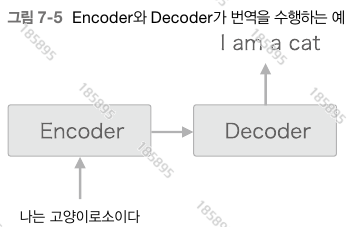

encoder에서는 인풋문장을 하나의 은닉벡터 h로 변환을 한다.

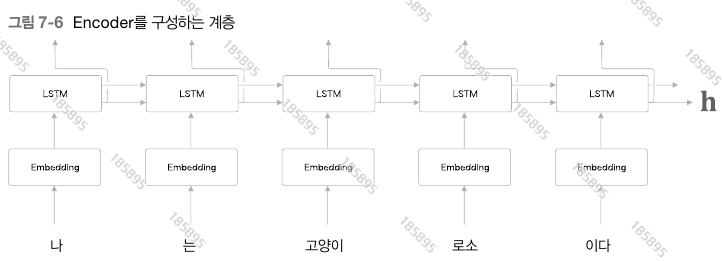

여기서 알아둬야할 점은 h는 계층 안에 있는 은닉 상태이므로 문장 길이나 그런거에 상관 없이 모델 자체의 구조에 고정되어있기 때문에 같은 모델이면 항상 고정길이로서 인코딩이 된다.

이제 encoding을 할때는 전에 생성하던것과 같긴 한데 은닉층에 이 h를 전달한다는 차이가 있다!

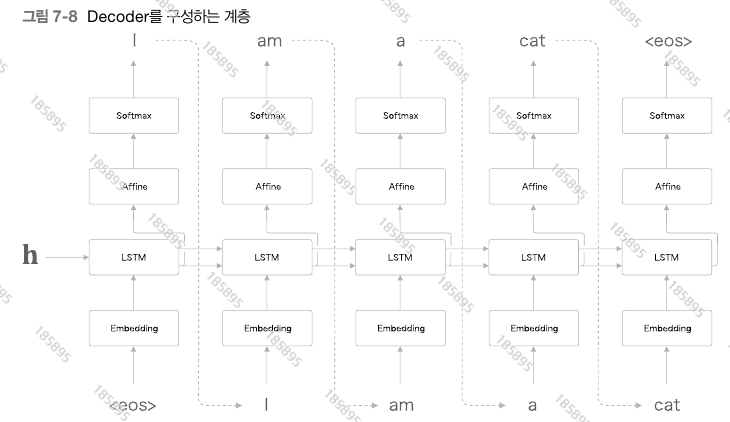

---

이 인코딩/디코딩 구조가 작동하는 모습을 보기위한 장난감 문제로 연산 문제를 만들 수 있다. 다음과같이 덧셈 학습을 위한 가변길이 문자를 준비할 수 있다.

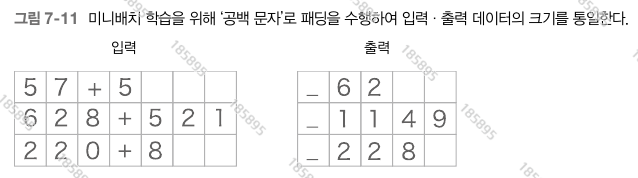

입력과 출력을 충분히 많이 학습시키면 얼추 덧셈을 할 수 있다고 한다.

훈련 데이터셋은 다음과 같다.

In [4]:
# coding: utf-8
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


인코더 코드는 다음과 같다

In [ ]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params  # 리스트
        self.grads = self.embed.grads + self.lstm.grads  # 리스트
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]  # 마지막 hidden state, 이걸 반환함. 

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

Decoder를 만들때에는 다음과 같이 LSTM레이어를 만드는데, 생성시에 시작토큰이 있어줘야하긴 하므로 (하지만 실제 생성은 h를 기반으로 하지만) 입력데이터는 '_'로 시작을 한다.

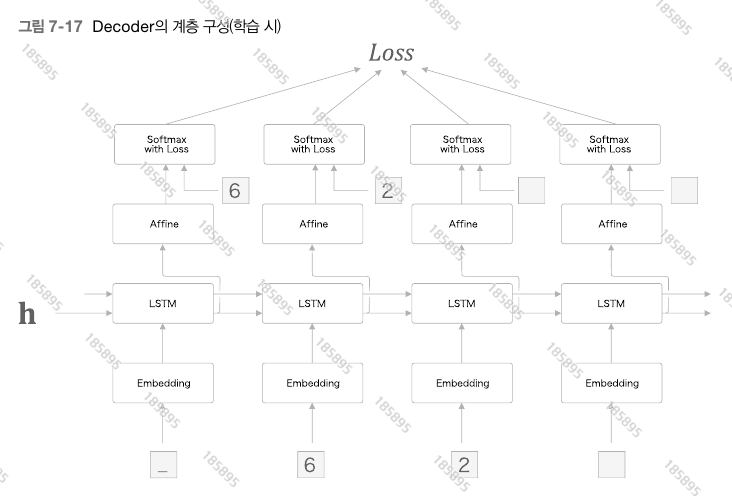

또, 답이 결정난 수학문제를 푸는거라고 볼 수 있으므로 확률적이 아닌 결정적으로 단어들을 선택한다. (inference할 때) 이를 위해서 최종 레이어에 보통 사용하던 softmax가 아니라 argmax를 사용하게 된다.

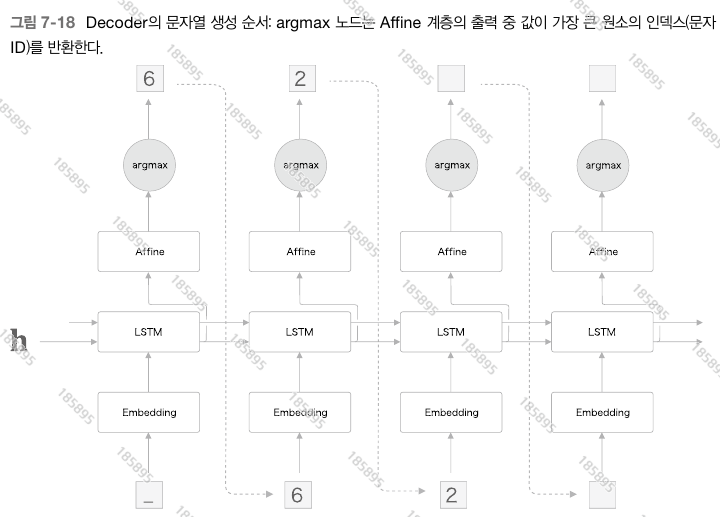

In [6]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

주목해야할 부분은 backwards 역전파 부분: 
```
softmax with loss -dscore-> Time Affine -> Time embedding
```
loss로부터 온 gradient dscore를 affine, LSTM, embedding 순서로 역전파.
TimeLSTM 내부에 시간 방향의 gradient인 dh가 저장되어 있고, 이 dh를 반환하여 상위(인코더)로 전달.

학습용과 생성용 동작은 분리되어 있음, `generate`를 통해서 

In [7]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

단순히 encode/decode레이어를 연결해주는 작업만 하면 됨.